### Mining of Massive Datasets HW 1

In [477]:
import findspark
findspark.init('/home/ek/spark-2.4.4-bin-hadoop2.7')
import pyspark
import os
java8_location= '/usr/lib/jvm/java-8-openjdk-amd64' # Set your own
os.environ['JAVA_HOME'] = java8_location
from pyspark.sql import SparkSession
import random
import time
from IPython.display import Image
from pyspark.sql.types import StructField,StringType,IntegerType,StructType
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler,StringIndexerModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel

### I.

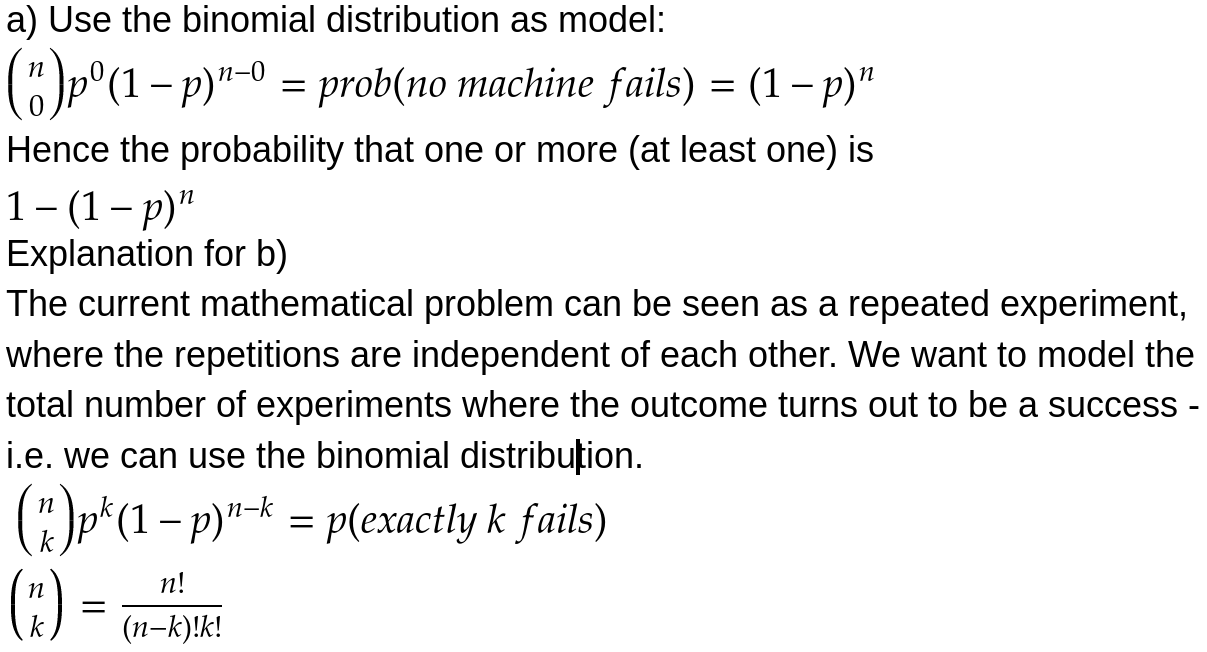

In [485]:
Image(filename = 'Pictures/ab.png')

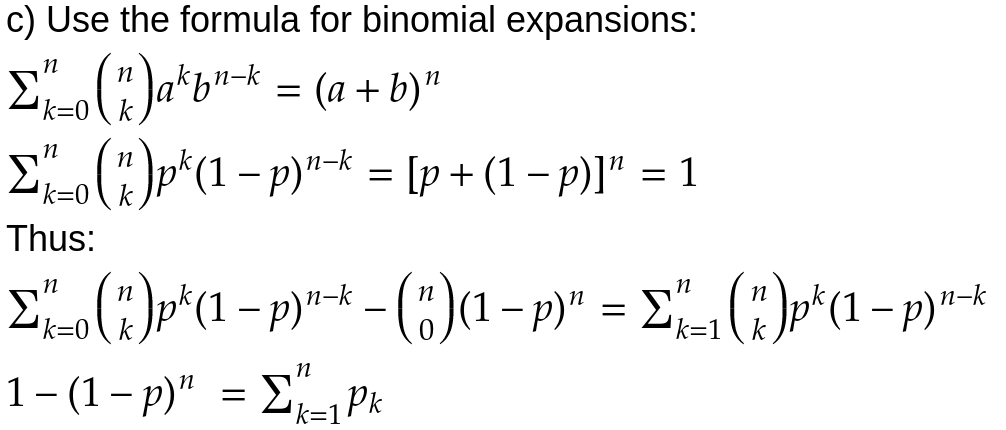

In [486]:
Image(filename = 'Pictures/c.png')

In [2]:
spark = SparkSession.builder.appName('first_assignment').getOrCreate()

### II.

For this exercise we define two dummy datasets, which we use in order to illustrate the way the join(), sortBy(), and groupBy()  

##### Define an RDD to work with

In [37]:
# our RDD contains the key value pairs of the type "item":contry_of_import
hw_RDD = spark.sparkContext.parallelize([
    ('item_1','BUL'),
    ('item_2','MKD'),
    ('item_2','BUL'),
    ('item_3','ROM')
])

##### II.a describe each of the following transformations 

##### join()

In [119]:
# join()
# let's first see an example:
# create a second rdd, which to use for the operation 
# second_rdd contains 'item':'country of export' key-value pairs
second_RDD = spark.sparkContext.parallelize([('item_2', 'FRA'), 
                                             ('item_2', 'GBR'), 
                                             ('item_4', 'ESP'), 
                                             ('item_3', 'ESP')])
join_RDD = hw_RDD.join(second_RDD)
join_RDD.collect()

[('item_2', ('MKD', 'FRA')),
 ('item_2', ('MKD', 'GBR')),
 ('item_2', ('BUL', 'FRA')),
 ('item_2', ('BUL', 'GBR')),
 ('item_3', ('ROM', 'ESP'))]

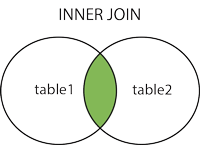

In [116]:
Image(filename = 'Downloads/innerjoin.gif')

The transformation is of the inner join type where the output contains only the rows with matrching keys from both datasets. From an rdd of type (K,V) and another of (K,W) the transformation returns an RDD of type (K, (V,W)). For our example we could use this to answers queries like : which countries have not bought goods from BUL and MKD, etc.

##### sortBy()

In [124]:
hw_RDD.sortBy(lambda x : x[0],ascending = False).collect()

[('item_3', 'ROM'), ('item_2', 'MKD'), ('item_2', 'BUL'), ('item_1', 'BUL')]

To understand what sortBy does let's look at the actual implementation of sortBy: 

self.keyBy(keyfunc).sortByKey(ascending, numPartitions).values() 

Here we see that it actually first sets a new key to the pair (the element we have specified in the keyfunc) and then sorts by that new key

##### groupBy()

In [137]:
result = join_RDD.groupBy(lambda x: x[1][1]).collect()

In [139]:
for country, info in result:
    print(country,': ',end='')
    for i in info:
        print(i,end=' ')
    print('\n')

FRA : ('item_2', ('MKD', 'FRA')) ('item_2', ('BUL', 'FRA')) 

GBR : ('item_2', ('MKD', 'GBR')) ('item_2', ('BUL', 'GBR')) 

ESP : ('item_3', ('ROM', 'ESP')) 



In [140]:
result = join_RDD.groupBy(lambda x: x[1][1]).map(lambda x: (x[0], len(x[1]))).collect()

In [141]:
result

[('FRA', 2), ('GBR', 2), ('ESP', 1)]

To understand what groupBy does let's look at the actual implementation of groupBy: 

self.map(lambda x: (f(x), x)).groupByKey(numPartitions)

As visible from the return value of the groupBy method it creates a key value pair with key the element we have chosen by the function we have passed and value - the whole row. After that a groupByKey operation is performed. In our example we have shown how this may be useful: for conducting aggregate operations - in this case count.

### IV.

##### IV a. 
read in the data as RDD, convert the data to DataFrame

In [3]:
# read in as RDD
dataset = spark.sparkContext.textFile('Downloads/adult.data').map(lambda x: x.split(', '))

In [4]:
dataset.take(5)[1] # check what the data looks like (as we see 1 new line in the text file== one row of data in the rdd)

['50',
 'Self-emp-not-inc',
 '83311',
 'Bachelors',
 '13',
 'Married-civ-spouse',
 'Exec-managerial',
 'Husband',
 'White',
 'Male',
 '0',
 '0',
 '13',
 'United-States',
 '<=50K']

clean the data

In [5]:
# find the source of the problems that might occur later: there is one row with a single element
dataset.map(lambda x:(x,len(x))).filter(lambda x: x[1]!=15).count()

1

In [99]:
dataset = dataset.filter(lambda x: len(x)==15).persist()

In [7]:
# get the names for the columns
names = []
with open('Downloads/adult.names') as f:
    for line in f:
        # most of the lines in this files are comments and begin with | or '\n'
        if line[0].isalpha(): 
            names.append(line.split(':')[0])

In [8]:
names.append('income')

In [9]:
names

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'income']

In [10]:

schema_DF = list(map(lambda x: StructField(x,StringType(),nullable = False),names))

In [11]:
len(schema_DF)

15

create dataFrame

In [171]:
dataset_DF = dataset.toDF(schema = StructType(schema_DF))

In [174]:
# recast education_num 
dataset_DF = dataset_DF.withColumn('new',dataset_DF['education-num'].cast('integer'))\
        .drop('education-num')\
        .withColumnRenamed('new','education_num')\
        .withColumn('new',dataset_DF['hours-per-week'].cast('integer'))\
        .drop('hours-per-week')\
        .withColumnRenamed('new','hours_per_week')\
        .withColumn('new',dataset_DF['capital-loss'].cast('integer'))\
        .drop('capital-loss')\
        .withColumnRenamed('new','capital_loss')\
        .withColumn('new',dataset_DF['capital-gain'].cast('integer'))\
        .drop('capital-gain')\
        .withColumnRenamed('new','capital_gain')\
        .withColumn('new',dataset_DF['age'].cast('integer'))\
        .drop('age')\
        .withColumnRenamed('new','age')\
        .withColumn('new',dataset_DF['fnlwgt'].cast('integer'))\
        .drop('fnlwgt')\
        .withColumnRenamed('new','fnlwgt')
dataset_DF = dataset_DF.withColumnRenamed('marital-status','marital_status')\
             .withColumnRenamed('native-country','native_country').persist().repartition(2)

In [175]:
dataset_DF.select('education_num').distinct().count() # test if there are any problems

16

##### IV b. 

ratio of males for each type of marital_status

In [77]:
all_genders_DF = dataset_DF.select(['sex','marital_status'])\
            .groupBy('marital_status')\
            .agg({'sex':'count'}).withColumnRenamed('count(sex)','total_count')

In [103]:
all_genders_DF = all_genders_DF.persist().repartition(1)

In [104]:
all_genders_DF.show()

+--------------------+-----------+
|      marital_status|total_count|
+--------------------+-----------+
|           Separated|       1025|
|       Never-married|      10683|
|Married-spouse-ab...|        418|
|            Divorced|       4443|
|             Widowed|        993|
|   Married-AF-spouse|         23|
|  Married-civ-spouse|      14976|
+--------------------+-----------+



In [105]:
male_only_DF = dataset_DF.select(['sex','marital_status'])\
                .filter(dataset_DF['sex']=='Male')\
                .groupBy('marital_status')\
                .agg({'sex':'count'}).withColumnRenamed('count(sex)','males_count')\
                .persist()\
                .repartition(1)

In [107]:
male_only_DF.show()

+--------------------+-----------+
|      marital_status|males_count|
+--------------------+-----------+
|           Separated|        394|
|       Never-married|       5916|
|Married-spouse-ab...|        213|
|            Divorced|       1771|
|             Widowed|        168|
|   Married-AF-spouse|          9|
|  Married-civ-spouse|      13319|
+--------------------+-----------+



In [108]:
join_DF = male_only_DF.join(all_genders_DF,on='marital_status')
join_DF = join_DF.withColumn('males_ratio',join_DF['males_count']/join_DF['total_count'])

In [109]:
join_DF.show()

+--------------------+-----------+-----------+-------------------+
|      marital_status|males_count|total_count|        males_ratio|
+--------------------+-----------+-----------+-------------------+
|           Separated|        394|       1025|0.38439024390243903|
|       Never-married|       5916|      10683| 0.5537770289244595|
|Married-spouse-ab...|        213|        418| 0.5095693779904307|
|            Divorced|       1771|       4443|0.39860454647760524|
|             Widowed|        168|        993| 0.1691842900302115|
|   Married-AF-spouse|          9|         23|  0.391304347826087|
|  Married-civ-spouse|      13319|      14976| 0.8893563034188035|
+--------------------+-----------+-----------+-------------------+



##### IV c. 
average hours_per_week of females who have income greater than 50K for each native_country

In [114]:
rich_women_DF = dataset_DF.select(['hours_per_week','native_country'])\
               .filter((dataset_DF['sex']=='Female') & (dataset_DF['income']=='>50K'))\
               .groupBy('native_country')\
               .agg({'hours_per_week':'avg'}).show()

+--------------+-------------------+
|native_country|avg(hours_per_week)|
+--------------+-------------------+
|   Philippines| 40.083333333333336|
|       Germany|  36.57142857142857|
|        France|               45.0|
|        Greece|               65.0|
|        Taiwan|              36.75|
|     Nicaragua|               35.0|
|          Hong|               40.0|
|         China|               33.6|
|         India|               38.5|
|         Italy|               42.0|
|          Cuba|               23.0|
|         South| 56.666666666666664|
|          Iran|               40.0|
|       Ireland|               40.0|
|          Laos|               40.0|
|      Thailand|               50.0|
|   El-Salvador|               40.0|
|        Mexico|               35.0|
|      Honduras|               60.0|
|    Yugoslavia|               40.0|
+--------------+-------------------+
only showing top 20 rows



##### IV d.
Get the highest and lowest level of education for each group of income . The highest level of education is the level with highest value of education_num

In [144]:
income_max_DF = dataset_DF.groupBy('income')\
               .agg({'education_num':'max'})\
               .withColumnRenamed('max(education_num)','max_num')

In [145]:
income_max_DF.show()

+------+-------+
|income|max_num|
+------+-------+
| <=50K|     16|
|  >50K|     16|
+------+-------+



In [146]:
income_max_DF = dataset_DF.select(['education_num','education'])\
                .join(income_max_DF.withColumnRenamed('max_num','education_num'),
                      on = 'education_num')\
                .distinct()

In [147]:
income_max_DF.show()

+-------------+---------+------+
|education_num|education|income|
+-------------+---------+------+
|           16|Doctorate|  >50K|
|           16|Doctorate| <=50K|
+-------------+---------+------+



In [148]:
income_min_DF = dataset_DF.groupBy('income')\
                .agg({'education_num':'min'})\
                .withColumnRenamed('min(education_num)','min_num')

In [149]:
income_min_DF.show()

+------+-------+
|income|min_num|
+------+-------+
| <=50K|      1|
|  >50K|      2|
+------+-------+



In [150]:
income_min_DF = dataset_DF.select(['education_num','education'])\
                .join(income_min_DF.withColumnRenamed('min_num','education_num'),
                      on = 'education_num')\
                .distinct()

In [151]:
income_min_DF.show()

+-------------+---------+------+
|education_num|education|income|
+-------------+---------+------+
|            2|  1st-4th|  >50K|
|            1|Preschool| <=50K|
+-------------+---------+------+



In [153]:
final_DF = income_min_DF.select(['education','income'])\
           .withColumnRenamed('education','education_min')\
           .join(income_max_DF.select(['education','income'])\
                         .withColumnRenamed('education','education_max'),on='income')

In [154]:
final_DF.show()

+------+-------------+-------------+
|income|education_min|education_max|
+------+-------------+-------------+
| <=50K|    Preschool|    Doctorate|
|  >50K|      1st-4th|    Doctorate|
+------+-------------+-------------+



### V

##### V a. 
preprocessing for usage with ML algorithms

In [377]:
categorical_variables = ['workclass', 
                         'education', 
                         'marital_status', 
                         'occupation', 
                         'relationship', 
                         'race', 
                         'sex', 
                         'native_country']

In [378]:
continuous_variables = ['age',
                        'fnlwgt',
                        'education_num',
                        'capital_gain',
                        'capital_loss',
                        'hours_per_week']

In [379]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"-index")\
            for column in categorical_variables]

In [380]:
encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{0}-encoded".format(indexer.getOutputCol()) for indexer in indexers]
)

In [381]:
encoder.getInputCols()

['workclass-index',
 'education-index',
 'marital_status-index',
 'occupation-index',
 'relationship-index',
 'race-index',
 'sex-index',
 'native_country-index']

In [382]:
assembler = VectorAssembler(
    inputCols=[*encoder.getOutputCols(),*continuous_variables],
    outputCol="features"
)

prepare the training data

In [383]:
pipeline = Pipeline(stages=indexers + [encoder, assembler])
train_df = pipeline.fit(dataset_DF).transform(dataset_DF)

In [384]:
    test_DF = spark.read.csv('Downloads/adult.test',schema = StructType(schema_DF),header = False,
                             ignoreLeadingWhiteSpace = True,ignoreTrailingWhiteSpace=True
                        )

pyspark does NOT strip the whitespaces, so casting to int would result in null values. To solve this we use ignoreLeading[Trailing]WhiteSpace = True. We also see in the data that the income values in this dataset end with a dot, which is not the case in the training dataset -> since those values are categorical we must make sure that the spelling of the classes in the training and test sets is identical : define a user defined function to delete the dots

In [385]:
from pyspark.sql.functions import udf
def delete_dot(string):
    return string[:-1]

delete_dot = udf(f = delete_dot)


In [386]:
test_DF = test_DF.withColumn('new',delete_dot(test_DF['income'])).drop('income').withColumnRenamed('new','income')

In [387]:
test_DF.show(1)

+---+---------+------+---------+-------------+--------------+-----------------+------------+-----+----+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education-num|marital-status|       occupation|relationship| race| sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---------+------+---------+-------------+--------------+-----------------+------------+-----+----+------------+------------+--------------+--------------+------+
| 25|  Private|226802|     11th|            7| Never-married|Machine-op-inspct|   Own-child|Black|Male|           0|           0|            40| United-States| <=50K|
+---+---------+------+---------+-------------+--------------+-----------------+------------+-----+----+------------+------------+--------------+--------------+------+
only showing top 1 row



In [388]:
# recast education_num 
test_DF = test_DF.withColumn('new',test_DF['education-num'].cast(IntegerType()))\
        .drop('education-num')\
        .withColumnRenamed('new','education_num')\
        .withColumn('new',test_DF['hours-per-week'].cast(IntegerType()))\
        .drop('hours-per-week')\
        .withColumnRenamed('new','hours_per_week')\
        .withColumn('new',test_DF['capital-loss'].cast(IntegerType()))\
        .drop('capital-loss')\
        .withColumnRenamed('new','capital_loss')\
        .withColumn('new',test_DF['capital-gain'].cast(IntegerType()))\
        .drop('capital-gain')\
        .withColumnRenamed('new','capital_gain')\
        .withColumn('new',test_DF['age'].cast(IntegerType()))\
        .drop('age')\
        .withColumnRenamed('new','age')\
        .withColumn('new',test_DF['fnlwgt'].cast(IntegerType()))\
        .drop('fnlwgt')\
        .withColumnRenamed('new','fnlwgt')
test_DF = test_DF.withColumnRenamed('marital-status','marital_status')\
             .withColumnRenamed('native-country','native_country').persist().repartition(2)

In [389]:
test_DF.printSchema()

root
 |-- workclass: string (nullable = true)
 |-- education: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- fnlwgt: integer (nullable = true)



In [390]:
test_DF.na.drop().count()

16281

Transform the test set (you MUST NOT! fit on the test set)

In [391]:
test_df = pipeline.fit(dataset_DF).transform(test_DF.na.drop())

create the class labels (ML algorithms in spark work only with numeric data so we have to use the StringIndexer again)

In [392]:
train_df.printSchema()

root
 |-- workclass: string (nullable = false)
 |-- education: string (nullable = false)
 |-- marital_status: string (nullable = false)
 |-- occupation: string (nullable = false)
 |-- relationship: string (nullable = false)
 |-- race: string (nullable = false)
 |-- sex: string (nullable = false)
 |-- native_country: string (nullable = false)
 |-- income: string (nullable = false)
 |-- education_num: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- workclass-index: double (nullable = false)
 |-- education-index: double (nullable = false)
 |-- marital_status-index: double (nullable = false)
 |-- occupation-index: double (nullable = false)
 |-- relationship-index: double (nullable = false)
 |-- race-index: double (nullable = false)
 |-- sex-index: double (nullable = false)
 |-- native_country-index

In [393]:
indexer = StringIndexer(inputCol='income', outputCol='label')
transformer = indexer.fit(train_df)
train_df = transformer.transform(train_df)
test_df = transformer.transform(test_df) # DO NOT fit on test sets!

In [398]:
train_df.select(['features','label']).show(5) # now let's see how the features and labels look 

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(100,[5,17,23,29,...|  1.0|
|(100,[0,15,23,34,...|  0.0|
|(100,[2,9,24,32,4...|  0.0|
|(100,[0,18,23,30,...|  1.0|
|(100,[0,8,23,32,4...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [401]:
lr = LogisticRegression(featuresCol='features', labelCol='label')
model = lr.fit(train_df)

In [402]:
pred = model.transform(test_df)

the summary options that the model provides us with do not automatically relate each weight to a predictor. To relate a weight to a predictor we have to get a list of the names of all predictors.In the metadata of the features column we can find the names of the predictors - for this we could use the encoded test/train dataset or the predictions 

In [425]:
from itertools import chain
encoded_predictors = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*test_df
        .schema['features']
        .metadata["ml_attr"]["attrs"].values())))

In [426]:
encoded_predictors[:5] # we see the names of the one hot encoded classes of the workclass predictor

[(0, 'workclass-index-encoded_Private'),
 (1, 'workclass-index-encoded_Self-emp-not-inc'),
 (2, 'workclass-index-encoded_Local-gov'),
 (3, 'workclass-index-encoded_?'),
 (4, 'workclass-index-encoded_State-gov')]

In [427]:
len(encoded_predictors)

100

to get the weights that the model has learned we can use the coefficients method

In [431]:
import pandas as pd # create a beautiful output on the notebook

In [436]:
data = [(model.coefficients[idx],attribute_name) for idx,attribute_name in encoded_predictors]

In [441]:
analysis_of_weights = pd.DataFrame(data,
             columns = ['attribute_name','attribute_weight'])

In [442]:
analysis_of_weights

,attribute_name,attribute_weight
0,-1.439816e+00,workclass-index-encoded_Private
1,-1.925903e+00,workclass-index-encoded_Self-emp-not-inc
2,-1.619346e+00,workclass-index-encoded_Local-gov
3,-7.751892e-01,workclass-index-encoded_?
4,-1.752209e+00,workclass-index-encoded_State-gov
5,-1.259380e+00,workclass-index-encoded_Self-emp-inc
6,-9.401555e-01,workclass-index-encoded_Federal-gov
7,-9.356385e+00,workclass-index-encoded_Without-pay
8,3.748254e-01,education-index-encoded_HS-grad
9,4.265981e-01,education-index-encoded_Some-college


In [466]:
model.save('model')

In [471]:
model = LogisticRegressionModel.load('model')

Have in mind though that only saving the model is NOT enough in a larger pipeline, because the preprocessing models will be lost and will have to be fitted on the training data again at the next loading of the model. You can save the preprocessing steps by calling save on the fitted transformer and you can load them by importing the <name_of_transformer>+Model and colling .load as a static function (as shown in the examples above and below) 

In [482]:
transformer.save('stringidx')

In [483]:
transformer = StringIndexerModel.load('stringidx') # load the string indexer for the labels